In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from diffusers import DDPMScheduler, UNet2DModel
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import logging
import time

# 创建日志记录器
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', handlers=[
    logging.FileHandler("training.log"),
    logging.StreamHandler()
])
logger = logging.getLogger()

# 创建 SummaryWriter
log_dir = 'runs/DDPM_experiment2'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir)

# 定义数据集类
class CatsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = plt.imread(img_path)
        if image.shape[-1] == 4:  # 如果是 RGBA，去掉 alpha 通道
            image = image[..., :3]
        image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        if self.transform:
            image = self.transform(image)
        return image

# 加载数据集并进行基本预处理
transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0 if x.dtype == torch.uint8 else x),
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = CatsDataset(data_dir='./DATA/train/cats', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# UNet 模型
model = UNet2DModel(
    sample_size=64,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
)

# 定义噪声调度器
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# 定义优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  

# 检查是否有可用的 GPU (MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
logger.info(f"Using device: {device}")
model.to(device)

# 定义梯度裁剪函数
def clip_gradients(optimizer, max_norm=1.0):
    for group in optimizer.param_groups:
        torch.nn.utils.clip_grad_norm_(group['params'], max_norm)

# 训练参数
epochs = 50

# 训练过程
for epoch in range(epochs):
    epoch_loss = 0
    start_time = time.time()
    for step, images in enumerate(train_dataloader):
        step_start_time = time.time()
        optimizer.zero_grad()

        clean_images = images.to(device)
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (clean_images.shape[0],), device=device).long()

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps).sample

        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        if torch.isnan(loss):
            logger.warning(f"NaN loss detected at Epoch {epoch+1}, Step {step}")
            continue
        
        loss.backward()
        
        # 应用梯度裁剪
        clip_gradients(optimizer, max_norm=1.0)
        
        optimizer.step()

        epoch_loss += loss.item()

        if step % 10 == 0:
            elapsed_time = time.time() - step_start_time
            logger.info(f"Epoch {epoch+1}, Step {step}, Loss: {loss.item():.4f}, Time per step: {elapsed_time:.4f}s")
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + step)
            
            # 生成新图像并保存
            with torch.no_grad():
                generated_images = model(noisy_images, timesteps).sample
                img_grid = torchvision.utils.make_grid(generated_images, normalize=True, value_range=(-1, 1))
                writer.add_image('Generated Images', img_grid, global_step=epoch * len(train_dataloader) + step)

                # 保存图像到文件系统
                save_image_path = f"generated_images/epoch_{epoch+1}_step_{step+1}.png"
                os.makedirs(os.path.dirname(save_image_path), exist_ok=True)
                torchvision.utils.save_image(generated_images, save_image_path, normalize=True, value_range=(-1, 1))
                logger.info(f"Saved generated image to {save_image_path}")

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    elapsed_epoch_time = time.time() - start_time
    logger.info(f"Epoch {epoch+1}, Average Loss: {avg_epoch_loss:.4f}, Time: {elapsed_epoch_time:.4f}s")
    writer.add_scalar('Average Epoch Loss', avg_epoch_loss, epoch)

# 保存模型
torch.save(model.state_dict(), 'ddpm_model.pth')
logger.info("Model saved as 'ddpm_model.pth'")

# 关闭 SummaryWriter
writer.close()
logger.info("Training complete.")

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <761A4B43-4CD1-322C-BB16-CEE783FE0A7C> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-07-17 17:24:59,135 - INFO - Using device: mps
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_87253/2065660197.py:42: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable t

In [2]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline.to(device)

# 生成图像
generator = torch.manual_seed(42)
images = pipeline(batch_size=10, generator=generator)["sample"]

# 显示生成的图像
plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i].permute(1, 2, 0)
    img = ((img + 1) / 2).clamp(0, 1)
    plt.imshow(img.cpu().numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'DDPMPipeline' is not defined

Saved generated images to ./generated.png


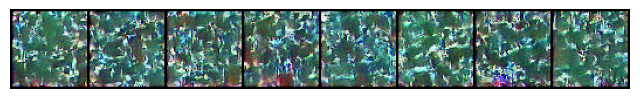

In [4]:
import torch
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel
import torchvision
import os
import matplotlib.pyplot as plt

# 定义噪声调度器
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# 定义并加载 UNet 模型
model = UNet2DModel(
    sample_size=64,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
)
model.load_state_dict(torch.load('ddpm_model.pth'))

# 检查是否有可用的 GPU (MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
model.eval()

# 图像生成函数
def generate_images(model, noise_scheduler, num_images=8):
    model.eval()
    with torch.no_grad():
        # 随机生成初始噪声图像
        noise = torch.randn((num_images, 3, 64, 64)).to(device)
        
        # 从噪声开始生成图像
        for t in reversed(range(noise_scheduler.config.num_train_timesteps)):
            timesteps = torch.tensor([t] * num_images, device=device)
            predicted_noise = model(noise, timesteps).sample
            noise = noise_scheduler.step(predicted_noise, t, noise).prev_sample

        # 将生成的图像从 [-1, 1] 转换到 [0, 1]
        generated_images = (noise.clamp(-1, 1) + 1) / 2

        # 生成图像网格
        img_grid = torchvision.utils.make_grid(generated_images, normalize=True, value_range=(0, 1))

        # 保存生成的图像
        os.makedirs('generated_images', exist_ok=True)
        save_image_path = f"./generated.png"
        torchvision.utils.save_image(generated_images, save_image_path, normalize=True, value_range=(0, 1))
        print(f"Saved generated images to {save_image_path}")

        # 显示生成的图像
        plt.figure(figsize=(8, 8))
        plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.show()

# 调用图像生成函数
generate_images(model, noise_scheduler, num_images=8)